In [1]:
import numpy as np
import tensorflow as tf

import sys
sys.path.append("..")

from models.regression_model import DemoRegressionDGP
from likelihoods import Gaussian
from utils_training import regression_train_demo

from matplotlib import pyplot as plt

2022-08-18 22:46:05.044945: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-08-18 22:46:06.142807: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-08-18 22:46:06.184025: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:25:00.0 name: NVIDIA RTX A5000 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 64 deviceMemorySize: 23.69GiB deviceMemoryBandwidth: 715.34GiB/s
2022-08-18 22:46:06.184054: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-08-18 22:46:06.187074: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-08-18 22:46:06.187104: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.

In [2]:
def get_sin_data(num_training, num_testing, std_noise=0.01):
    X_1 = np.random.uniform(-2., -1., num_training//2)
    X_2 = np.random.uniform(1., 2., num_training - num_training//2)
    X_train = np.concatenate([X_1, X_2])
    Y_train = np.sin(np.pi * X_train) + np.random.randn(num_training) * std_noise
    X_train = np.reshape(X_train, [num_training, 1])
    Y_train = np.reshape(Y_train, [num_training, 1])
    #nomalize the data
    y_mean = np.average(Y_train)
    y_std = np.std(Y_train)
    Y_train = (Y_train - y_mean)/y_std
    
    X_test = np.linspace(-5., 5., num_testing)[:, None]
    Y_test = (np.sin(np.pi * X_test) - y_mean)/y_std
    
    return np.float32(X_train), np.float32(Y_train), np.float32(X_test), np.float32(Y_test)

def load_demo_data(num_training, num_testing, batch_size, std_noise=0.01):
    X_train, Y_train, X_test, Y_test= get_sin_data(num_training, num_testing, std_noise=std_noise)
    ds_X_train = tf.data.Dataset.from_tensor_slices(X_train)
    ds_Y_train = tf.data.Dataset.from_tensor_slices(Y_train)
    ds_train = tf.data.Dataset.zip((ds_X_train, ds_Y_train))
    ds_X_test = tf.data.Dataset.from_tensor_slices(X_test)
    ds_Y_test = tf.data.Dataset.from_tensor_slices(Y_test)
    ds_test = tf.data.Dataset.zip((ds_X_test, ds_Y_test))

    ds_train = ds_train.shuffle(num_training)
    # ds_test = ds_test.shuffle(num_testing)
    ds_train = ds_train.batch(batch_size) # not using full data as one batch
    ds_test = ds_test.batch(num_testing)
    return ds_train, ds_test, X_test

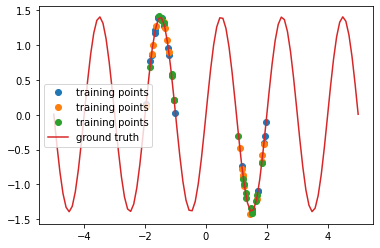

In [3]:
num_training = 60
num_testing = 100
batch_size = 20
std_noise = 0.02

ds_train, ds_test, X_test = load_demo_data(num_training, num_testing, batch_size, std_noise=std_noise)
for x, y in ds_train:
    plt.plot(x[:,0], y[:,0], 'o',linewidth=0.5, label='training points')
for x, y in ds_test:
    plt.plot(x[:,0], y[:,0], label='ground truth')
plt.legend()
plt.savefig('sin.png')

# 1-layer GPs (fixing kernel params)

In [4]:
# initialize the model
d_in = 1
d_out = 1
model = DemoRegressionDGP(d_in, d_out, n_hidden_layers=1, n_rf=300, n_gp=1,
                          likelihood=Gaussian(variance=0.01, trainable=False),
                          kernel_type_list=['RBF'], kernel_trainable=False,
                          random_fixed=True, input_cat=False)

In [5]:
model.kernel_list[0].length_scale

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>

In [6]:
# training settings
lr_0 = 0.02
beta = 0.99
total_epochs = 2000
start_sampling_epoch = 0
epochs_per_cycle = 50
print_epoch_cycle = 50

In [7]:
_, _, lines, W = regression_train_demo(model, ds_train, ds_test, num_training, batch_size, X_test,
                                                              lr_0=lr_0, momentum_decay=beta,
                                                              resample_in_cycle_head = True, total_epochs=total_epochs,
                                                              start_sampling_epoch=start_sampling_epoch,
                                                              epochs_per_cycle=epochs_per_cycle,
                                                              print_epoch_cycle=print_epoch_cycle)

2022-08-18 22:46:23.637809: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-08-18 22:46:23.657074: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-08-18 22:46:24.207080: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-08-18 22:46:24.207140: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


#################### Sampling at Epoch 49  lr = 2.404305921022143e-10 ####################
Epoch: 49
Mean Log Likelihood -- train: -3.2274527549743652, -- test: -161.53231811523438 
Root Mean Squared Error -- train: 0.30368074774742126, -- test: 1.8050814867019653 
 
#################### Sampling at Epoch 99  lr = 2.404305921022143e-10 ####################
Epoch: 99
Mean Log Likelihood -- train: -0.8412550687789917, -- test: -109.19140625 
Root Mean Squared Error -- train: 0.21094556152820587, -- test: 1.4871116876602173 
 
#################### Sampling at Epoch 149  lr = 2.404305921022143e-10 ####################
Epoch: 149
Mean Log Likelihood -- train: -0.1592094749212265, -- test: -112.59858703613281 
Root Mean Squared Error -- train: 0.17566195130348206, -- test: 1.509849190711975 
 
#################### Sampling at Epoch 199  lr = 2.404305921022143e-10 ####################
Epoch: 199
Mean Log Likelihood -- train: -0.28652849793434143, -- test: -89.46097564697266 
Root Mean Squared

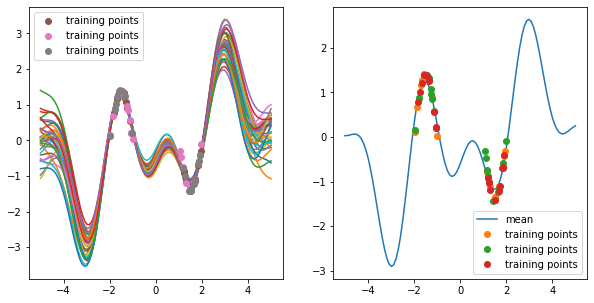

In [8]:
# print sampled lines
fig, ax = plt.subplots(1, model.n_hidden_layers+1, figsize=((model.n_hidden_layers+1)*5, 5))
ax = ax.flatten()
for i in range(model.n_hidden_layers):
    for model_line in lines[5:]: # hidden outputs of each sampled model
        line = model_line[i]
        ax[i].plot(X_test[:,0], line.numpy()[:,0])
    # for model_line in lines[690:701]: # hidden outputs of each sampled model
    #     line = model_line[i]
    #     ax[i].plot(X_test.numpy()[:,0], line.numpy()[:,0], 'b')
for x, y in ds_train:
    ax[-2].plot(x[:,0], y[:,0], 'o', label='training points')
# for x, y in ds_test:
    # ax[-1].plot(x[:,0], y[:,0], '*', label='ground truth')
ax[-2].legend()

# compute the mean of the sampled lines
line_output = []
for model_line in lines[5:]:
    line_output.append(model_line[-1]) #the final layer
line_mean = tf.reduce_mean(tf.concat(line_output, axis=-1), axis=-1)
ax[-1].plot(X_test[:,0], line_mean.numpy(), label='mean')
for x, y in ds_train:
    ax[-1].plot(x[:,0], y[:,0], 'o', label='training points')
ax[-1].legend()
fig.savefig('1layer-sin-2.png')

# 2-layer DGPs (fixing kernel params)

In [31]:
# initialize the model
d_in = 1
d_out = 1
model = DemoRegressionDGP(d_in, d_out, n_hidden_layers=2, n_rf=100, n_gp=1,
                          likelihood=Gaussian(variance=0.01, trainable=False),
                          kernel_type_list=['RBF' for i in range(2)], kernel_trainable=False,
                          random_fixed=True, input_cat=False)

In [32]:
model.kernel_list[0].length_scale

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>

In [33]:
# training settings
lr_0 = 0.01
beta = 0.95
total_epochs = 50000
start_sampling_epoch = 0
epochs_per_cycle = 50
print_epoch_cycle = 50

In [34]:
_, _, lines, W = regression_train_demo(model, ds_train, ds_test, num_training, batch_size, X_test,
                                                              lr_0=lr_0, momentum_decay=beta,
                                                              resample_in_cycle_head=True, total_epochs=total_epochs,
                                                              start_sampling_epoch=start_sampling_epoch,
                                                              epochs_per_cycle=epochs_per_cycle,
                                                              print_epoch_cycle=print_epoch_cycle)

#################### Sampling at Epoch 49  lr = 1.2021529605110715e-10 ####################
Epoch: 49
Mean Log Likelihood -- train: -4.4278364181518555, -- test: -236.41014099121094 
Root Mean Squared Error -- train: 0.3409247100353241, -- test: 2.1807971000671387 
 
#################### Sampling at Epoch 99  lr = 1.2021529605110715e-10 ####################
Epoch: 99
Mean Log Likelihood -- train: 0.8276434540748596, -- test: -121.66314697265625 
Root Mean Squared Error -- train: 0.10545171052217484, -- test: 1.5687371492385864 
 
#################### Sampling at Epoch 149  lr = 1.2021529605110715e-10 ####################
Epoch: 149
Mean Log Likelihood -- train: 1.2723612785339355, -- test: -113.35786437988281 
Root Mean Squared Error -- train: 0.04717741534113884, -- test: 1.5148696899414062 
 
#################### Sampling at Epoch 199  lr = 1.2021529605110715e-10 ####################
Epoch: 199
Mean Log Likelihood -- train: 1.2079519033432007, -- test: -117.07125854492188 
Root Mean 

2022-08-18 22:58:48.981943: W tensorflow/core/kernels/data/model_dataset_op.cc:205] Optimization loop failed: Cancelled: Operation was cancelled


#################### Sampling at Epoch 1899  lr = 1.2021529605110715e-10 ####################
Epoch: 1899
Mean Log Likelihood -- train: 1.0505468845367432, -- test: -35.619407653808594 
Root Mean Squared Error -- train: 0.08162102848291397, -- test: 0.8602679967880249 
 
#################### Sampling at Epoch 1949  lr = 1.2021529605110715e-10 ####################
Epoch: 1949
Mean Log Likelihood -- train: 1.161551833152771, -- test: -34.821353912353516 
Root Mean Squared Error -- train: 0.06664755940437317, -- test: 0.8509405851364136 
 
#################### Sampling at Epoch 1999  lr = 1.2021529605110715e-10 ####################
Epoch: 1999
Mean Log Likelihood -- train: 1.1047008037567139, -- test: -38.109886169433594 
Root Mean Squared Error -- train: 0.07469213008880615, -- test: 0.8887466788291931 
 
#################### Sampling at Epoch 2049  lr = 1.2021529605110715e-10 ####################
Epoch: 2049
Mean Log Likelihood -- train: 1.2374458312988281, -- test: -34.887874603271484 

2022-08-18 23:02:08.009970: W tensorflow/core/kernels/data/model_dataset_op.cc:205] Optimization loop failed: Cancelled: Operation was cancelled


#################### Sampling at Epoch 8399  lr = 1.2021529605110715e-10 ####################
Epoch: 8399
Mean Log Likelihood -- train: 1.1494673490524292, -- test: -40.0403938293457 
Root Mean Squared Error -- train: 0.06843671202659607, -- test: 0.9102091789245605 
 
#################### Sampling at Epoch 8449  lr = 1.2021529605110715e-10 ####################
Epoch: 8449
Mean Log Likelihood -- train: 0.7212646007537842, -- test: -19.038463592529297 
Root Mean Squared Error -- train: 0.11509839445352554, -- test: 0.6390948295593262 
 
#################### Sampling at Epoch 8499  lr = 1.2021529605110715e-10 ####################
Epoch: 8499
Mean Log Likelihood -- train: 1.0393961668014526, -- test: -16.31137466430664 
Root Mean Squared Error -- train: 0.08297596126794815, -- test: 0.5948952436447144 
 
#################### Sampling at Epoch 8549  lr = 1.2021529605110715e-10 ####################
Epoch: 8549
Mean Log Likelihood -- train: 1.0830405950546265, -- test: -49.6280517578125 
Roo

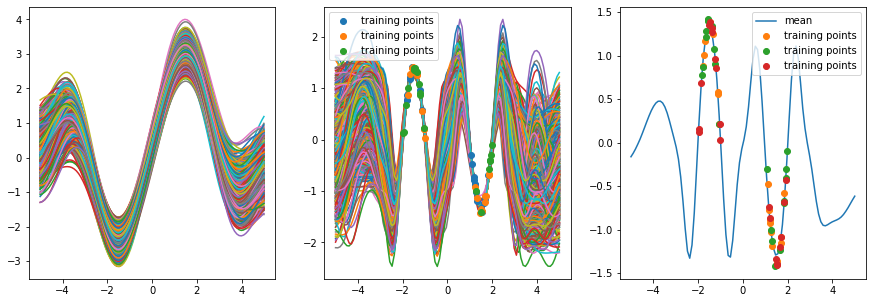

In [36]:
# print sampled lines
fig, ax = plt.subplots(1, model.n_hidden_layers+1, figsize=((model.n_hidden_layers+1)*5, 5))
ax = ax.flatten()
for i in range(model.n_hidden_layers):
    for model_line in lines[10:]: # hidden outputs of each sampled model
        line = model_line[i]
        ax[i].plot(X_test[:,0], line.numpy()[:,0])
    # for model_line in lines[690:701]: # hidden outputs of each sampled model
    #     line = model_line[i]
    #     ax[i].plot(X_test.numpy()[:,0], line.numpy()[:,0], 'b')
for x, y in ds_train:
    ax[-2].plot(x[:,0], y[:,0], 'o', label='training points')
# for x, y in ds_test:
    # ax[-1].plot(x[:,0], y[:,0], '*', label='ground truth')
ax[-2].legend()

# compute the mean of the sampled lines
line_output = []
for model_line in lines[10:]:
    line_output.append(model_line[-1]) #the final layer
line_mean = tf.reduce_mean(tf.concat(line_output, axis=-1), axis=-1)
ax[-1].plot(X_test[:,0], line_mean.numpy(), label='mean')
for x, y in ds_train:
    ax[-1].plot(x[:,0], y[:,0], 'o', label='training points')
ax[-1].legend()
# fig.savefig('2layer-sin.png')

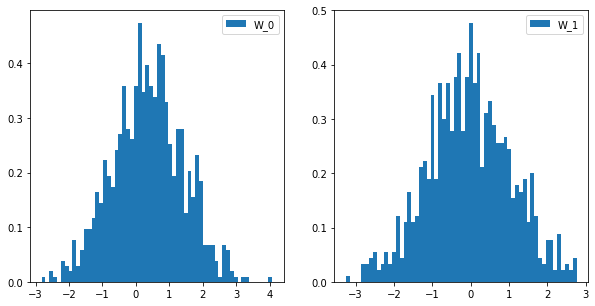

In [38]:
print_index = (25,0)
fig, ax = plt.subplots(1, model.n_hidden_layers, figsize=(model.n_hidden_layers*5,5))
ax = ax.flatten()
for i in range(model.n_hidden_layers):
    W_print = []
    for W_model in W['W_'+str(i)][100:]:
        W_print.append(W_model[print_index])
    ax[i].hist(W_print, bins=60, density=True, label='W_'+str(i))
    ax[i].legend()
fig.savefig('2w-sin-2.png')

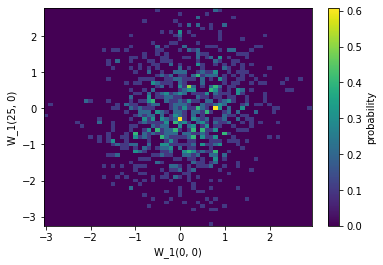

In [41]:
# try to show the correlation of two weights
print_index_1 = (0,0)
print_index_2 = (25,0)
W_print_1 = []
W_print_2 = []
for W_model in W['W_'+ str(1)][10:]:
    W_print_1.append(W_model[print_index_1])
    W_print_2.append(W_model[print_index_2])
plt.hist2d(W_print_1, W_print_2, bins=60, density=True)
plt.xlabel(f'W_1{print_index_1}')
plt.ylabel(f'W_1{print_index_2}')
cbar = plt.colorbar()
cbar.ax.set_ylabel('probability')
plt.savefig('correlation-sin-2.png')